## 图结构数据的度

## citeseer

In [15]:
from deeprobust.graph.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt

data = Dataset(root='./Datasets/', name='citeseer')
adj, features, labels = data.adj, data.features, data.labels
degree = adj.sum(0).A1
nclass = labels.max().item()+1
print(nclass)

Loading citeseer dataset...
Selecting 1 largest connected components
6


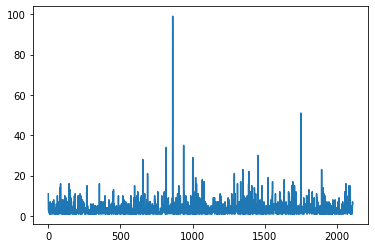

In [8]:
plt.plot(degree)

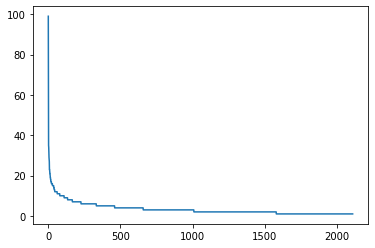

In [9]:
plt.plot(sorted(degree, reverse=True))

In [10]:
print(degree.shape)
print(degree[degree<10].shape)

print(degree<5)

(2110,)
(2000,)
[False  True  True ... False False False]


In [18]:
import random

print(random.randrange(1,2000))

1104


## cora

In [14]:
from deeprobust.graph.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt

data = Dataset(root='./Datasets/', name='cora')
adj, features, labels = data.adj, data.features, data.labels
degree = adj.sum(0).A1
nclass = labels.max().item()+1
print(nclass)

Loading cora dataset...
Selecting 1 largest connected components
7


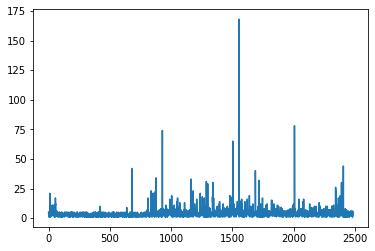

In [12]:
plt.plot(degree)

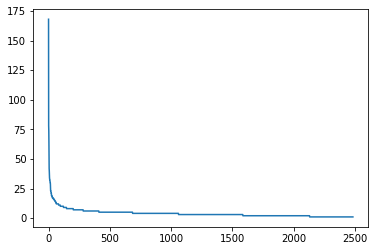

In [13]:
plt.plot(sorted(degree, reverse=True))